# Testing baseline SARIMA with exogenous variables (SARIMAX). 

## Evaluation of final baseline model will be performed between the comparison of best model with and without exogenous variables

In [39]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [41]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [43]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [45]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [47]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [49]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.85 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

- SARIMAX model being tested by random parameters with yearly seasonality (12 weeks). 

The workflow of SARIMAX will follow the same path as the SARIMA: 
- Random parameter: Random values, starting point for hyper-parameter tunning.

- Hyper-parameter tunning: Auto-arima and Random Search. The first will search through combinations that has the lower AIC value and the second will be performed along with cross validation techniques searching for the best RMSE.

- Cross-Validation: Time-Series and Fixed Rolling Window.

- Residuals: The analysis will be performed on the best model.   

**The evaluation of results and performance of each model will be at the end, when all models have being applied along with cross-validation techniques**. 






Performing auto-arima to find optimal parameters using two different frequencies monthly and quaterly. 

### AUTO-ARIMA

- 52 Weeks Frequency (One Year)

In [23]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=52,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=37.48 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-4339.778, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-4341.742, Time=9.53 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-4342.023, Time=15.57 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-4336.565, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=-4340.943, Time=0.08 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=-4339.446, Time=9.09 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=-4340.763, Time=58.88 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=-4341.804, Time=3.68 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=-4338.816, Time=70.22 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=-4340.717, Time=2.56 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=-4340.079, Time=12.53 sec
 ARIMA(0,0,2)(0,0,1)[52] intercept   : AIC=-4340.094, Time=9.14 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=-4341.959, Time=29.39 sec
 ARIM

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  876
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 52)   Log Likelihood                2561.460
Date:                            Sat, 16 Nov 2024   AIC                          -5106.920
Time:                                    10:16:19   BIC                          -5068.717
Sample:                                04-01-2004   HQIC                         -5092.308
                                     - 01-07-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      2.4154      0.081     29.831      0.000       2.257       2.574
rolling_mean_12w 

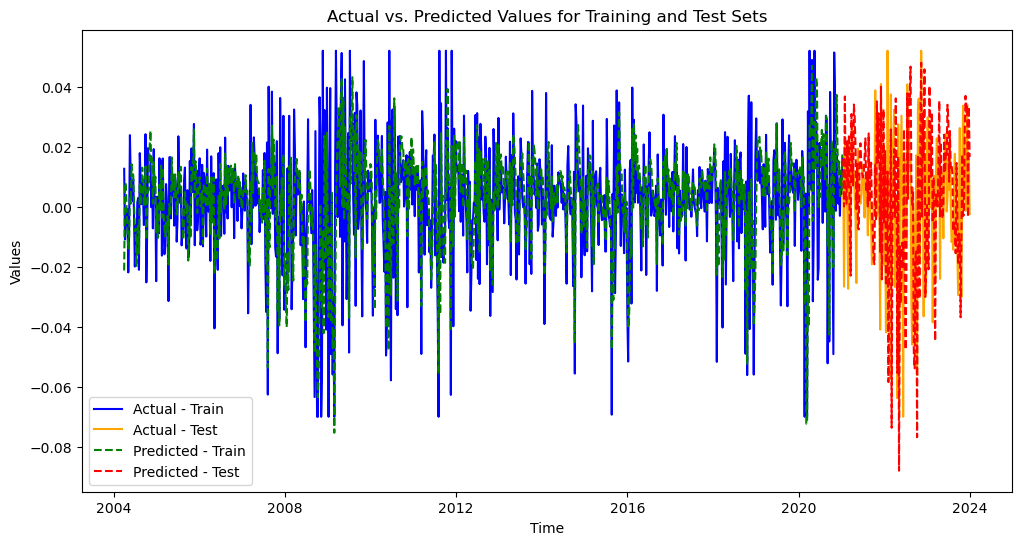

In [38]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [11]:
# Sets random seed for reproducibility.
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables.
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=26,  # Set seasonality period, e.g., 52 for weekly data with yearly seasonality.
                        trace=True,  # Prints the model selection process.
                        error_action='ignore',  # Ignore models that fail to fit.
                        suppress_warnings=True,  # Suppress warnings.
                        stepwise=True,  # Stepwise approach for faster search.
                        random=True,  # Random search.
                        random_state=42,  # Seed for reproducibility.
                        n_fits=50)  # Number of models to try.

# Print the best model found.
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=-4339.778, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=-4338.919, Time=1.33 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=-4339.022, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=-4336.565, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[26] intercept   : AIC=-4337.786, Time=0.50 sec
 ARIMA(0,0,0)(0,0,1)[26] intercept   : AIC=-4337.650, Time=0.46 sec
 ARIMA(0,0,0)(1,0,1)[26] intercept   : AIC=-4336.043, Time=0.82 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=-4340.851, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[26] intercept   : AIC=-4338.927, Time=1.30 sec
 ARIMA(1,0,0)(1,0,1)[26] intercept   : AIC=-4337.185, Time=1.07 sec
 ARIMA(2,0,0)(0,0,0)[26] intercept   : AIC=-4339.098, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[26] intercept   : AIC=-4339.059, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=-4340.943, Time=0.09 sec
 ARIMA(0,0,

- 26 Weeks Frequency (Half-Year)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  876
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2508.926
Date:                Thu, 07 Nov 2024   AIC                          -5003.852
Time:                        11:20:36   BIC                          -4970.424
Sample:                    04-01-2004   HQIC                         -4991.066
                         - 01-07-2021                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.9155      0.090     21.285      0.000       1.739       2.092
rolling_mean_12w     0.1292      0.132      0.982      0.326      -0.129       0.387
volatility_4w    -3.924e-06 

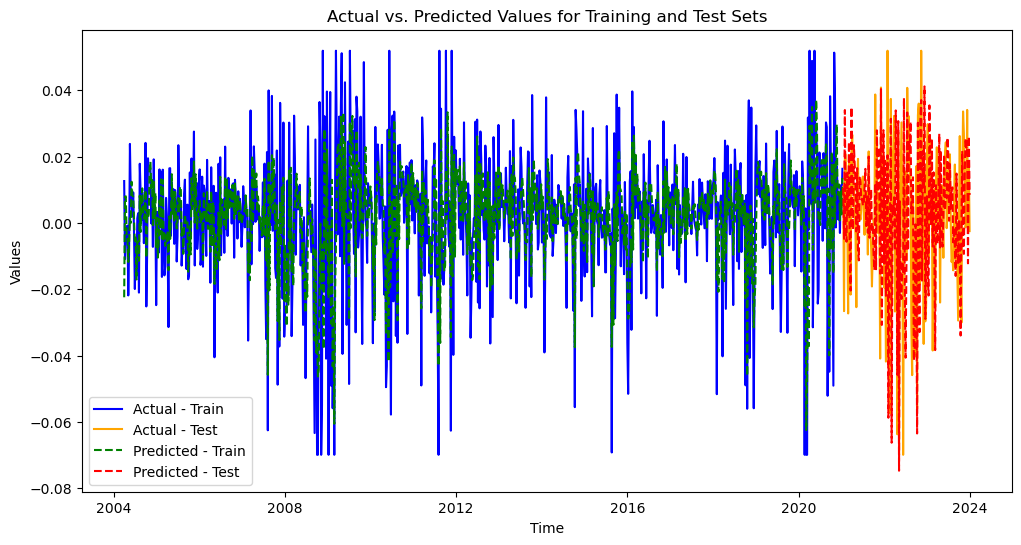

In [14]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- 12 Weeks (Quaterly)

In [15]:
# Sets random seed for reproducibility
np.random.seed(42)

# Perform auto_arima with specified seed and exogenous variables
auto_model = auto_arima(train, 
                        exogenous=exo_train, 
                        seasonal=True,
                        m=12,  # Set seasonality period, e.g., 12 for weekly data with quaterly seasonality
                        trace=True,  # Prints the model selection process
                        error_action='ignore',  # Ignore models that fail to fit
                        suppress_warnings=True,  # Suppress warnings
                        stepwise=True,  # Stepwise approach for faster search
                        random=True,  # Random search
                        random_state=42,  # Seed for reproducibility
                        n_fits=50)  # Number of models to try

# Print the best model found
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-4339.778, Time=0.33 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-4341.316, Time=1.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-4341.459, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-4336.565, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-4340.943, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-4339.420, Time=1.37 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-4339.562, Time=4.30 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-4341.399, Time=0.86 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=-4337.567, Time=3.35 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-4340.320, Time=2.57 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-4339.534, Time=1.73 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=-4339.565, Time=0.98 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-4341.377, Time=0.95 sec
 ARIMA(1,0,

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  876
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2373.790
Date:                            Thu, 07 Nov 2024   AIC                          -4731.579
Time:                                    11:21:09   BIC                          -4693.376
Sample:                                04-01-2004   HQIC                         -4716.966
                                     - 01-07-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4016      0.082     17.039      0.000       1.240       1.563
rolling_mean_12w 

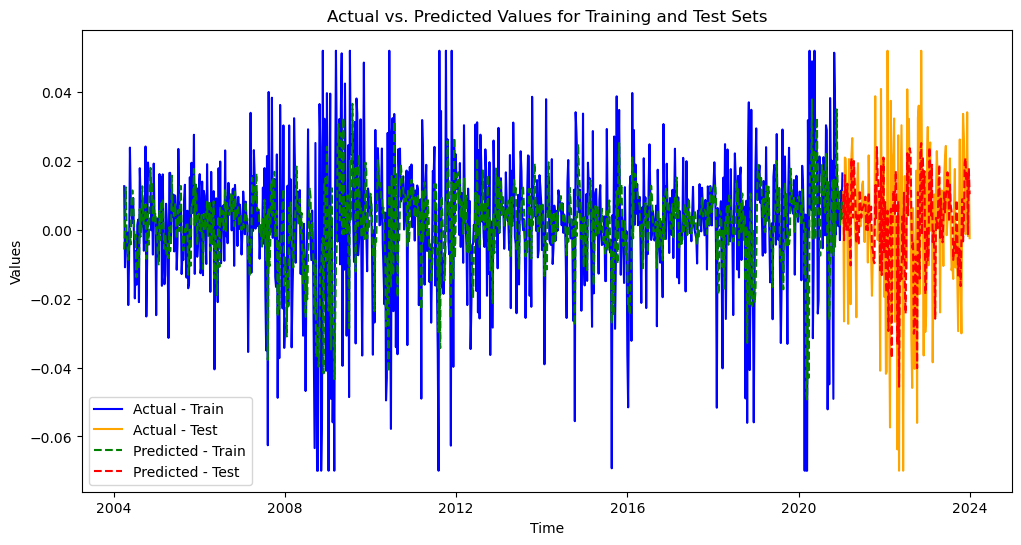

In [16]:
# Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- With different types of hyper-parameter tunning, the random search will be selected to to find the optimal parameters (30 different). The selection is due to the trade-off between range of values and computational resources (takes too long to run). In addition, a random state will be added to ensure reproducibility (same results).
- Grid Search was attempted but it was extremely computational expensive (especially for m=52).

Instead of applying the random search on a simple train and test set, the approach will be performed along with cross validation, providing a more reliable RMSE across differend folds. Despite being more computational expensive it will validade the model at the same time. 

<b> Six Months Frequency (m=26) </b>

- Random Search + TSCV

In [13]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]
}

# Number of combinations to try.
n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA with cross-validation.
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only)
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.016398041998857266
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.02701503380019172
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.028082165464511928
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.033242616405612165
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03298434645581286
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.0320031562811026
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 26, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.016340535654099066
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 26, 'd': 1, 'Q': 0, 'P':

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(0, 0, 3)x(2, 0, [1, 2], 26)   Log Likelihood                2574.376
Date:                                 Sat, 16 Nov 2024   AIC                          -5122.752
Time:                                         10:14:01   BIC                          -5060.673
Sample:                                     04-01-2004   HQIC                         -5099.007
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.6614      0.070     23.655      0.000  

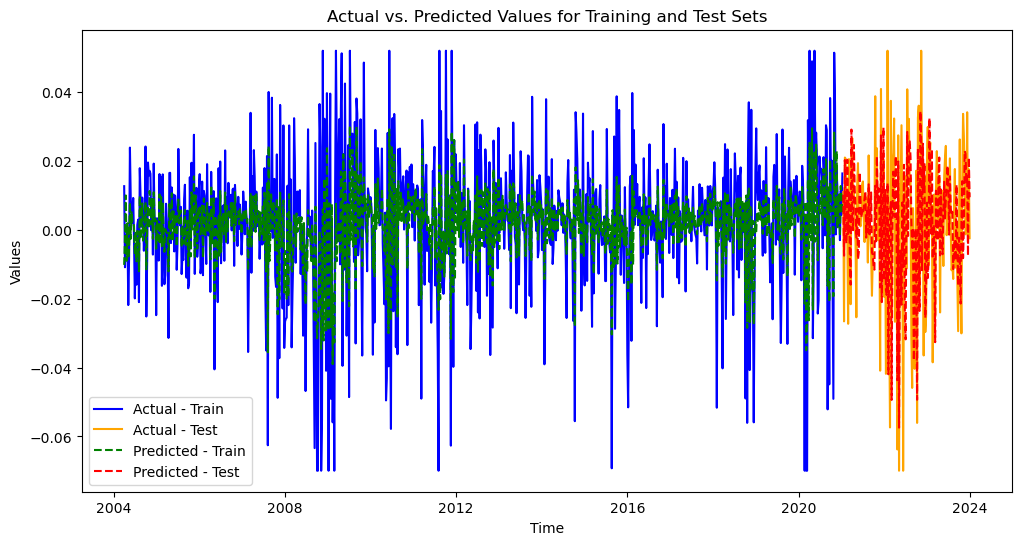

In [30]:
# Time-Series CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 3), seasonal_order=(2, 0, 2, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

- The present parameter presents the lower AIC at thi point (-5117.63).
- The model summary shows that the feature rolling_mean_4w has great impact, meanwhile lag_1 has a negative effect.  

- Random Search + Fixed Rolling window CV

In [14]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.01532684785912528
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.023766640114537066
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.025531503711990602
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.03166791271882883
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 26)   Log Likelihood                2537.120
Date:                                 Sat, 16 Nov 2024   AIC                          -5048.240
Time:                                         10:15:14   BIC                          -4986.160
Sample:                                     04-01-2004   HQIC                         -5024.494
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4171      0.093     15.243      0.000  

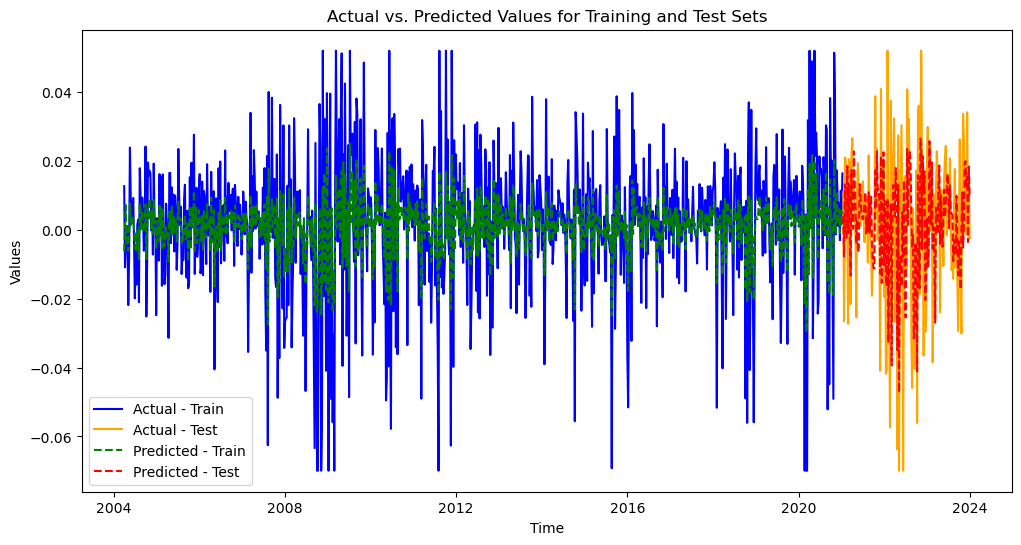

In [34]:
# Fixed Rolling window CV. 
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 26), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.027206412733342383
4 week (one month) Horizon MAE: 0.02099725380879987
4 week (one month) Horizon Directional Accuracy: 94.84%


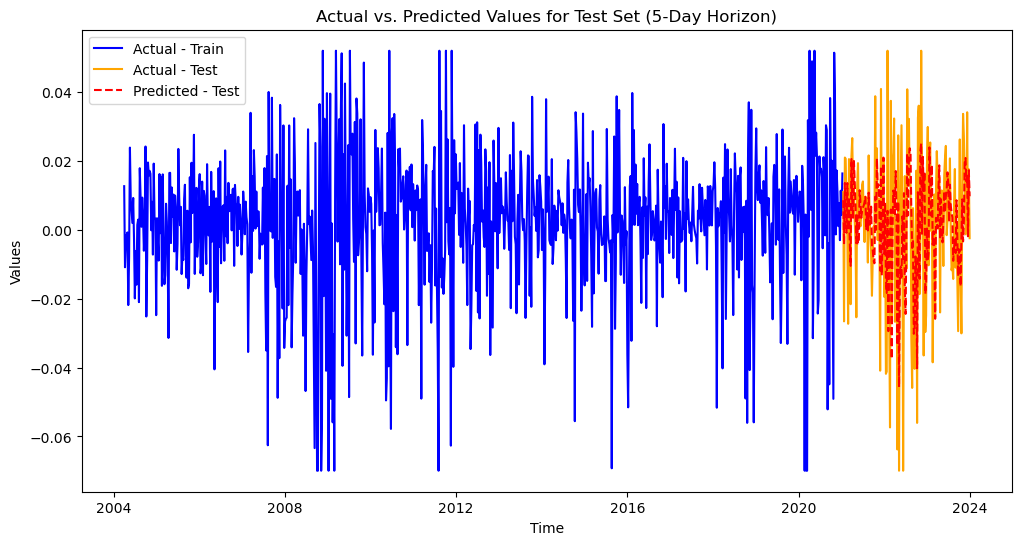

In [23]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

<b> Quaterly frequency (m=12) </b>

- Random Search + TSCV

In [129]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.01656583352345243
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.027054542096896048
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.03224330997998976
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.033720696816152654
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03565111227401974
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.03655693611192263
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 12, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.016431659384905824
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 12, 'd': 1, 'Q': 0, 'P':

In [132]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE
best_rmse = np.inf
best_params = None

# Fixed Rolling Window Cross-Validation Configuration
window_size = 300  # Training window size to align with initial TSCV window.
test_size = 50     # Test window size to match TSCV.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower.
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}")  # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.01537876747704418
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 1, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.023657310102617346
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 12, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.0276248081123065
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.03723788139074072
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 12, 'd': 1, 'Q': 0, 'P

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                2571.814
Date:                                 Sat, 16 Nov 2024   AIC                          -5117.628
Time:                                         10:18:32   BIC                          -5055.549
Sample:                                     04-01-2004   HQIC                         -5093.883
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.6479      0.071     23.374      0.000  

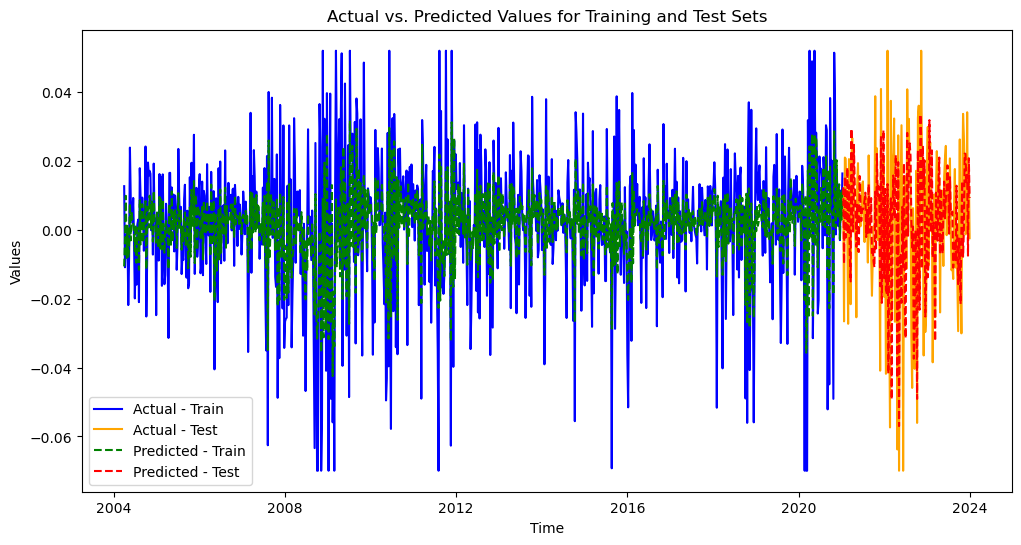

In [40]:
# Fixed Rolling window CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.028734191563165
4 week (one month) Horizon MAE: 0.022083582601103952
4 week (one month) Horizon MAPE: 442.8963252799583
5-Day Horizon Directional Accuracy: 94.84%


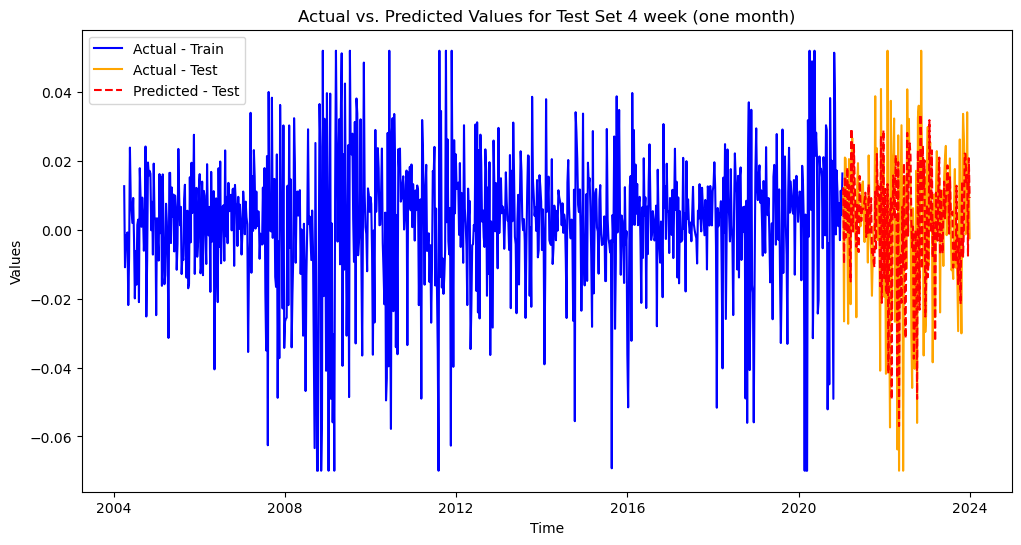

In [41]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate MAPE over the 4 week (one month) horizon.
fours_weeks_mape = np.mean(np.abs((test[horizon:] - test_predictions[:-horizon]) / test[horizon:])) * 100

# Calculate 5-day Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print("4 week (one month) Horizon MAPE:", fours_weeks_mape)
print(f"5-Day Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set 4 week (one month)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

m=52

- Random Search + Fixed Rolling window CV

In [16]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]  # Seasonal period.
}

# Number of random parameter combinations to try.
n_iter_search = 30  
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation.
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]

        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}: 0.015051068516615916
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}: 0.02367484302232472
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}: 0.030450298483141357
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}: 0.03649349905891296
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average Rolling Window RMSE for parameters {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 

- Random Search + TSCV

In [18]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              exog=X_train,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.016600944302742428
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.026459314015843206
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 52, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.03040903536703151
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.03140279042420219
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.030458056123259754
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 52, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.031805923294803015
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 52, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.016431764232831277
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 52, 'd': 1, 'Q': 0, 'P

- The parameters given by the Random Search + TSCV and Random Search + Fixed Rolliong Window are the same (1,0,3 - 1,0,2, 52)

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Tue, 19 Nov 2024   AIC                          -5049.025
Time:                                         13:20:06   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

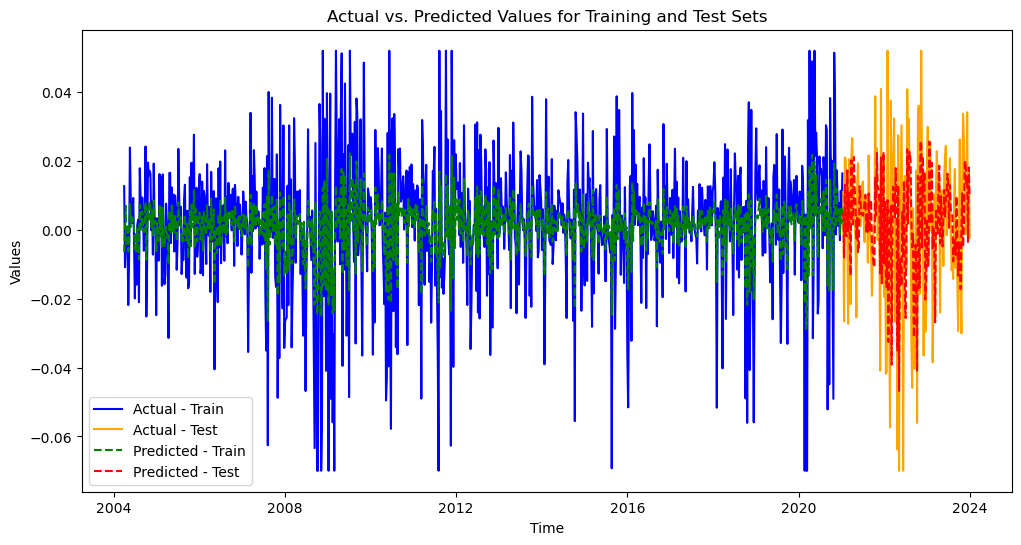

In [36]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

### SARIMAX Model Performance Metrics

#### Seasonality = 12
| Metric         | Auto-Arima    | Random Search |
|-----------------|---------------|---------------|
| **Train RMSE** | 0.016103111   | 0.012844322   |
| **Test RMSE**  | 0.018923832   | 0.019624817   |
| **Train MAE**  | 0.011818088   | 0.00944154    |
| **Test MAE**   | 0.014793849   | 0.015327288   |
| **Train DA**   | 99%           | 99%           |
| **Test DA**    | 98%           | 98%           |




#### Seasonality = 26
| Metric         | Auto-Arima    | Random Search |
|-----------------|---------------|---------------|
| **Train RMSE** | 0.013797655   | 0.013359493   |
| **Test RMSE**  | 0.021643653   | 0.019168111   |
| **Train MAE**  | 0.010028601   | 0.009801086   |
| **Test MAE**   | 0.017044175   | 0.015107057   |
| **Train DA**   | 99%           | 99%           |
| **Test DA**    | 98%           | 98%           |




#### Seasonality = 52
| Metric         | Auto-Arima    | Random Search |
|-----------------|---------------|---------------|
| **Train RMSE** | 0.013012951   | 0.013354765   |
| **Test RMSE**  | 0.022596461   | 0.019127401   |
| **Train MAE**  | 0.00959674    | 0.009800038   |
| **Test MAE**   | 0.018292133   | 0.015007735   |
| **Train DA**   | 99%           | 99%           |
| **Test DA**    | 98%           | 98%           |

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  876
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2373.790
Date:                            Tue, 19 Nov 2024   AIC                          -4731.579
Time:                                    12:56:42   BIC                          -4693.376
Sample:                                04-01-2004   HQIC                         -4716.966
                                     - 01-07-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4016      0.082     17.039      0.000       1.240       1.563
rolling_mean_12w 

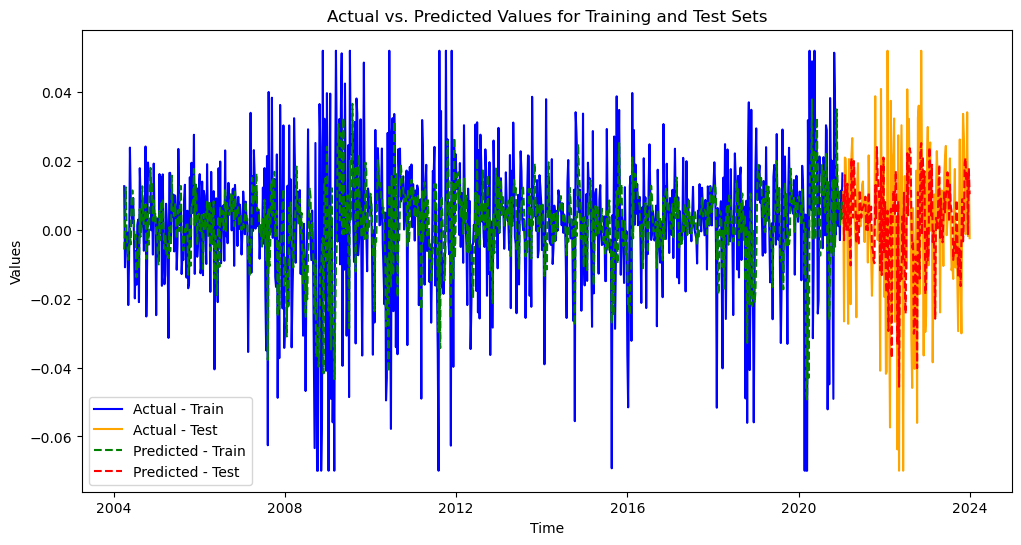

In [26]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [16]:
# Optimal parameters from random search
optimal_params = {
    'p': 0,   
    'd': 0,   
    'q': 1,  
    'P': 0,   
    'D': 0,   
    'Q': 1,   
    'm': 12   # (seasonal period)
}
p, d, q = optimal_params['p'], optimal_params['d'], optimal_params['q']
P, D, Q, m = optimal_params['P'], optimal_params['D'], optimal_params['Q'], optimal_params['m']

# TSCV Setup
n_splits = 4
test_window = 50
initial_train_window = len(train) - n_splits * test_window

# Function to evaluate SARIMA with TSCV
def tscv_evaluate_sarima(params):
    """
    Perform TSCV on SARIMA with given parameters and return average RMSE.
    """
    rmse_scores = []
    
    for i in range(n_splits):
        # Define train and test indices for each fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        X_train, X_test = exo_train[:train_end], exo_train[train_end:test_end]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed on fold {i+1}: {e}")
            return np.inf  # Assign high error if model fails
    
    # Return the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Run TSCV evaluation
tscv_rmse = tscv_evaluate_sarima(optimal_params)
print(f"TSCV Average RMSE: {tscv_rmse}")

TSCV Average RMSE: 0.0176784318995938


In [24]:
# Fixed Rolling Window Setup
window_size = 300  # Training window size
test_size = 50     # Test window size

# Function to evaluate SARIMA with fixed rolling window
def fixed_rolling_evaluate_sarima(params):
    """
    Perform Fixed Rolling Window evaluation on SARIMA with given parameters and return average RMSE.
    """
    rolling_rmses = []
    
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
        X_train = exo_train[i:i + window_size]
        X_test = exo_train[i + window_size:i + window_size + test_size]
        
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                exog=X_train,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            
            # Forecast on the test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed on rolling window iteration {i+1}: {e}")
            rolling_rmses.append(np.inf)
    
    # Return the average RMSE across all rolling windows
    avg_rmse = np.mean(rolling_rmses)
    return avg_rmse

# Run Fixed Rolling Window evaluation
fixed_rolling_rmse = fixed_rolling_evaluate_sarima(optimal_params)
print(f"Fixed Rolling Window Average RMSE: {fixed_rolling_rmse}")

Fixed Rolling Window Average RMSE: 0.015454640797394024


### Cross-Validation Results for Different Seasonal Periods.

| Seasonality (m) | Cross-Validation Type            | RMSE          |
|------------------|----------------------------------|---------------|
| **m = 12**      | Time Series Cross-Validation    | 0.017678432   |
|                  | Forward Rolling Window Cross-Validation | 0.015454641   |
| **m = 26**      | Time Series Cross-Validation    | 0.016351521   |
|                  | Forward Rolling Window Cross-Validation | 0.015000404   |
| **m = 52**      | Time Series Cross-Validation    | 0.016404902   |
|                  | Forward Rolling Window Cross-Validation | 0.014884936   |

- **RMSE:** Measure of prediction accuracy, lower values indicating better performance.

---

#### Observations:
- **Forward Rolling Window Cross-Validation consistently achieves lower RMSE** across all seasonal periods, indicating it might be more representative of real-world forecasting scenarios.
- The lowest RMSE overall is observed for **m = 52 with Forward Rolling Window Cross-Validation (0.014884936)**, suggesting strong performance for long seasonal periods. Also, it almosnt has no difference (only 0.0005) compared with the lowest TSCV (observed in m=26).

### Residuals check for the the two best performers. 

**In order to select the final baseline model, residuals are going be analysed**. The investigation will be start:
- By looking at the ACF and PACF (if the model capture the dependecies in the series), all the lags should be inside the shaded area (confidence of internval).
- Q-Q plot and histograms, will check the normality of the data. It should follow a normal distribution.
- Ljung-Box Test for Autocorrelation, it will provide support to the ACF/PACF plots, it will try to detect slight autocorrelations that visually might challenging.
-  ARCH Test, a value that is going to be calculated to check if the series presents times of high and low variance, volatility clustering. Ideally, the p-value has to be above 0.05 to indicate homoscedastic.
-  Residuals Overtime, visuallt check variance and volatility clustering.


#### Residual Analysis of model 1 - Random Search with Frequency = 52

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Thu, 05 Dec 2024   AIC                          -5049.025
Time:                                         16:25:39   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

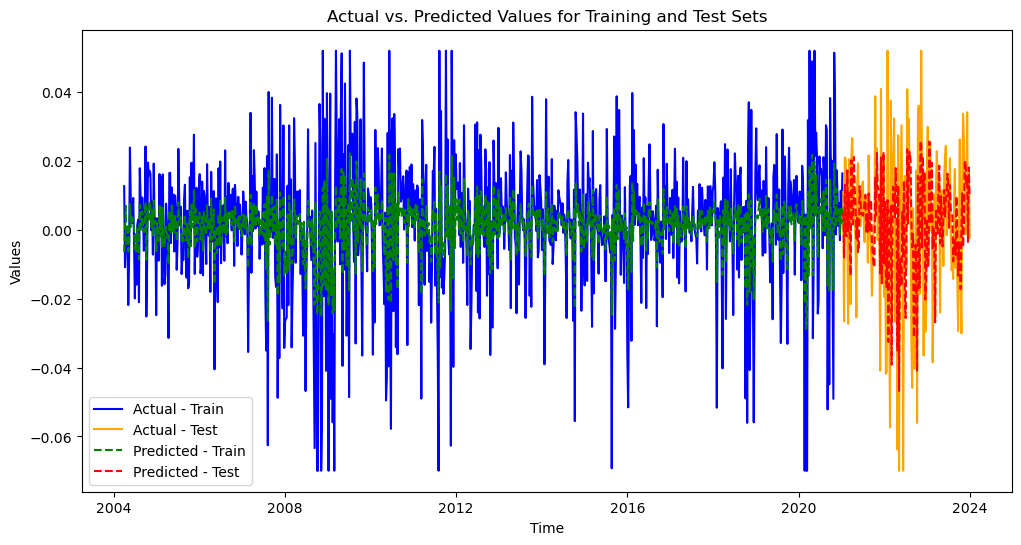

In [14]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_52 = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_52.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_52.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_52.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

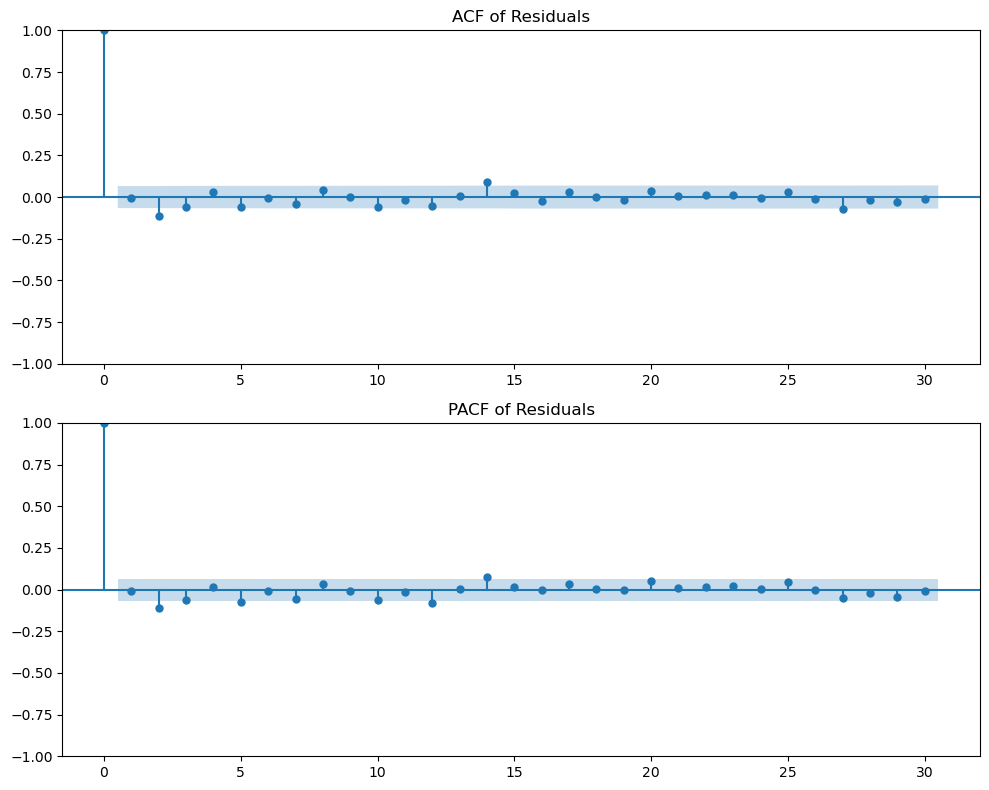

In [51]:
# Calculate residuals from the fitted model.
residuals_52 = sarimax_final_52.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

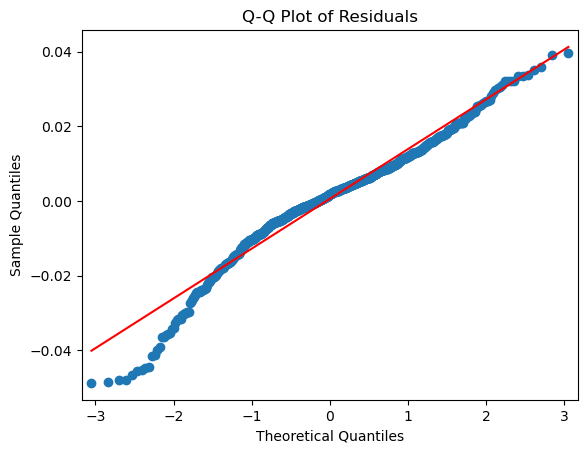

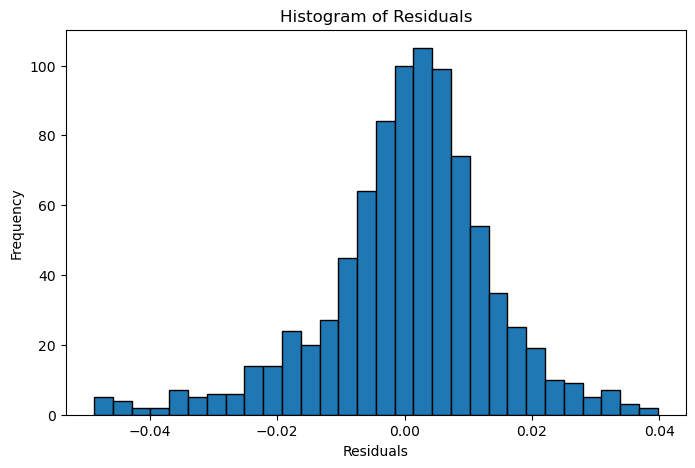

In [52]:
# Q-Q plot for normality check.
sm.qqplot(residuals_52, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals_52, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [53]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals_52, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals_52)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results

      lb_stat  lb_pvalue
10  24.333845   0.006762
20  37.871745   0.009181
30  44.706827   0.041094
ARCH Test p-value: 7.96929136614076e-24


In [51]:
# Define TSCV parameters
n_splits = 4  # Number of splits
test_window = 50
initial_train_window = len(train) - n_splits * test_window
tscv = TimeSeriesSplit(n_splits=n_splits)

# Placeholder for metrics
tscv_rmse = []
tscv_mae = []
tscv_da = []

# Perform TSCV
for fold, (train_idx, val_idx) in enumerate(tscv.split(train), 1):  # Enumerate to keep track of fold numbers
    # Define train and validation sets
    y_train, y_val = train.iloc[train_idx], train.iloc[val_idx]
    X_train, X_val = exo_train.iloc[train_idx], exo_train.iloc[val_idx]

    # Fit SARIMAX model on training set
    model = SARIMAX(y_train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=X_train)
    results = model.fit(disp=False)

    # Forecast/validate
    val_predictions = results.forecast(steps=len(y_val), exog=X_val)

    # Calculate metrics
    rmse = mean_squared_error(y_val, val_predictions, squared=False)
    mae = mean_absolute_error(y_val, val_predictions)
    da = np.mean(
        np.sign(val_predictions[:-1] - val_predictions[1:]) == np.sign(y_val[:-1] - y_val[1:])
    ) * 100

    # Append metrics
    tscv_rmse.append(rmse)
    tscv_mae.append(mae)
    tscv_da.append(da)

    # Print metrics for the current fold
    print(f"Fold {fold} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Directional Accuracy: {da:.2f}%")

# Calculate and print average metrics across all folds
print("\nAverage Metrics Across All Folds:")
print(f"  Avg RMSE: {np.mean(tscv_rmse):.4f}")
print(f"  Avg MAE: {np.mean(tscv_mae):.4f}")
print(f"  Avg Directional Accuracy: {np.mean(tscv_da):.2f}%")

Fold 1 Metrics:
  RMSE: 0.0233
  MAE: 0.0180
  Directional Accuracy: 98.86%
Fold 2 Metrics:
  RMSE: 0.0152
  MAE: 0.0118
  Directional Accuracy: 98.86%
Fold 3 Metrics:
  RMSE: 0.0129
  MAE: 0.0094
  Directional Accuracy: 98.86%
Fold 4 Metrics:
  RMSE: 0.0185
  MAE: 0.0134
  Directional Accuracy: 98.86%

Average Metrics Across All Folds:
  Avg RMSE: 0.0174
  Avg MAE: 0.0132
  Avg Directional Accuracy: 98.86%


In [52]:
# Define FRWCV parameters
train_window = 300  # Number of observations in training window
test_window = 50    # Number of observations in test window
rolling_rmse = []
rolling_mae = []
rolling_da = []

# Perform Fixed Rolling Window Cross-Validation
for start in range(0, len(train) - train_window - test_window, test_window):
    # Define rolling train and test sets
    y_train = train[start:start + train_window]
    y_test = train[start + train_window:start + train_window + test_window]
    X_train = exo_train[start:start + train_window]
    X_test = exo_train[start + train_window:start + train_window + test_window]

    # Fit SARIMAX model on training set
    model = SARIMAX(y_train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=X_train)
    results = model.fit(disp=False)

    # Forecast/test
    test_predictions = results.forecast(steps=len(y_test), exog=X_test)

    # Calculate metrics
    rmse = mean_squared_error(y_test, test_predictions, squared=False)
    mae = mean_absolute_error(y_test, test_predictions)
    da = np.mean(
        np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(y_test[:-1] - y_test[1:])
    ) * 100

    # Append metrics
    rolling_rmse.append(rmse)
    rolling_mae.append(mae)
    rolling_da.append(da)

    # Print metrics for the current window
    print(f"Window {start // test_window + 1}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, DA = {da:.2f}%")

# Calculate average metrics
print("\n--- Final Averages ---")
print(f"Rolling Window RMSE: {np.mean(rolling_rmse):.4f}")
print(f"Rolling Window MAE: {np.mean(rolling_mae):.4f}")
print(f"Rolling Window Directional Accuracy: {np.mean(rolling_da):.2f}%")

Window 1: RMSE = 0.0182, MAE = 0.0138, DA = 96.00%
Window 2: RMSE = 0.0193, MAE = 0.0150, DA = 96.00%
Window 3: RMSE = 0.0126, MAE = 0.0107, DA = 96.00%
Window 4: RMSE = 0.0128, MAE = 0.0102, DA = 96.00%
Window 5: RMSE = 0.0116, MAE = 0.0082, DA = 96.00%
Window 6: RMSE = 0.0154, MAE = 0.0122, DA = 96.00%
Window 7: RMSE = 0.0167, MAE = 0.0127, DA = 96.00%
Window 8: RMSE = 0.0081, MAE = 0.0063, DA = 96.00%
Window 9: RMSE = 0.0133, MAE = 0.0094, DA = 96.00%
Window 10: RMSE = 0.0169, MAE = 0.0125, DA = 96.00%
Window 11: RMSE = 0.0214, MAE = 0.0162, DA = 96.00%

--- Final Averages ---
Rolling Window RMSE: 0.0151
Rolling Window MAE: 0.0116
Rolling Window Directional Accuracy: 96.00%


#### Residual Analysis of model 2 - Auto-Arima Frequency = 12

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  876
Model:             SARIMAX(0, 0, 1)x(0, 0, 1, 12)   Log Likelihood                2373.790
Date:                            Tue, 19 Nov 2024   AIC                          -4731.579
Time:                                    14:18:20   BIC                          -4693.376
Sample:                                04-01-2004   HQIC                         -4716.966
                                     - 01-07-2021                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4016      0.082     17.039      0.000       1.240       1.563
rolling_mean_12w 

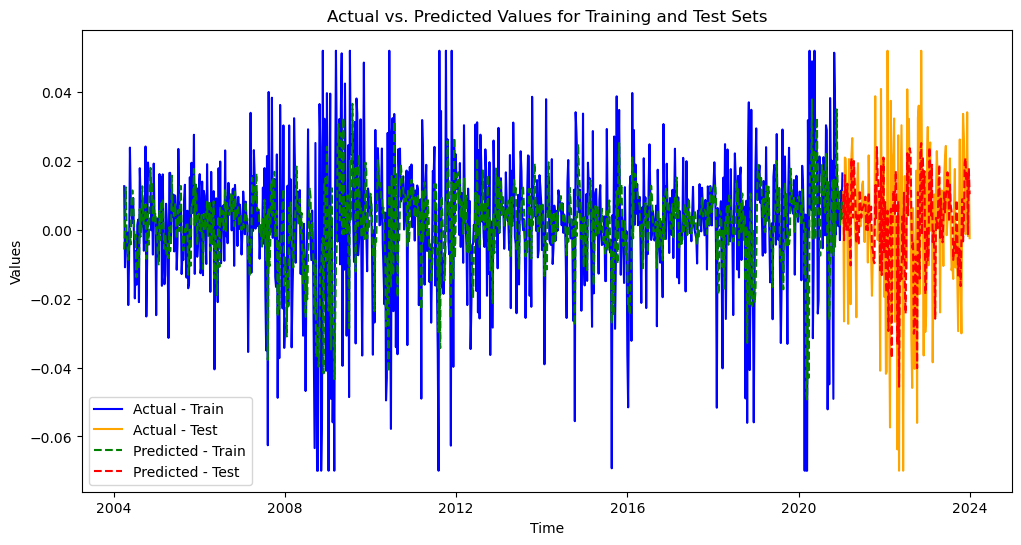

In [54]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12), exog=exo_train)
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

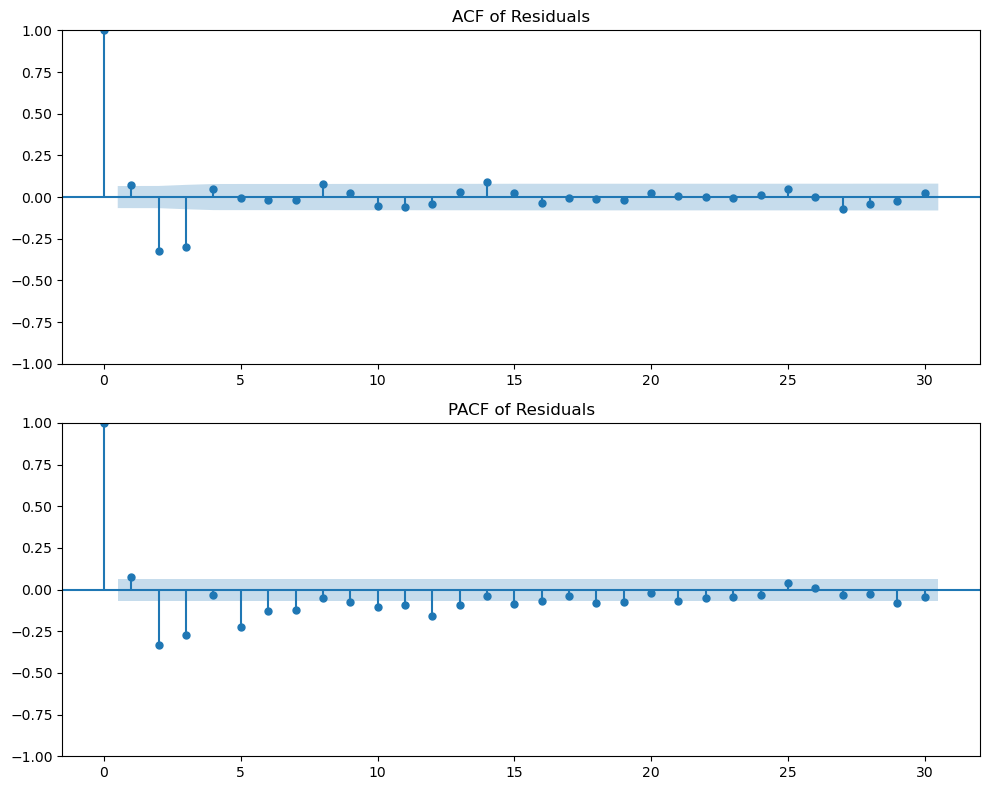

In [55]:
# Calculate residuals from the fitted model.
residuals = sarimax_final_fitted.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

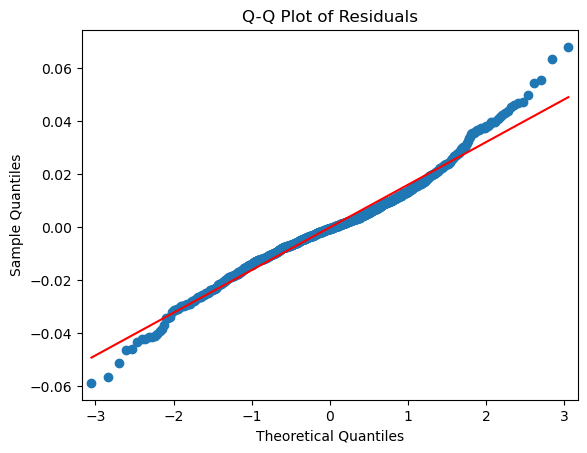

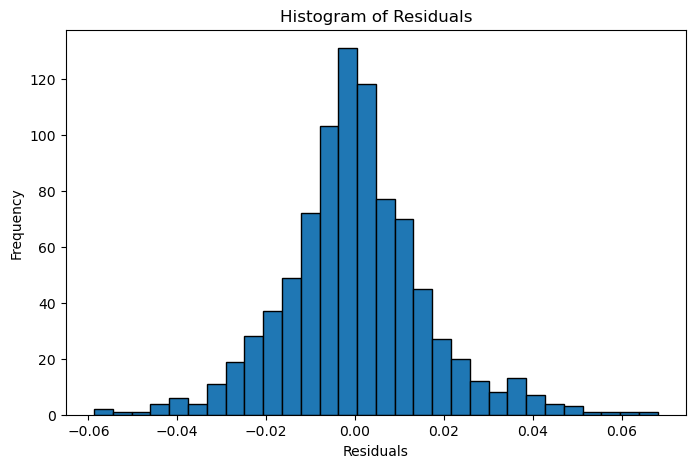

In [56]:
# Q-Q plot for normality check.
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [57]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results.

       lb_stat     lb_pvalue
10  186.655076  9.705212e-35
20  202.412362  3.748111e-32
30  211.595038  3.280279e-29
ARCH Test p-value: 4.53854381990896e-33


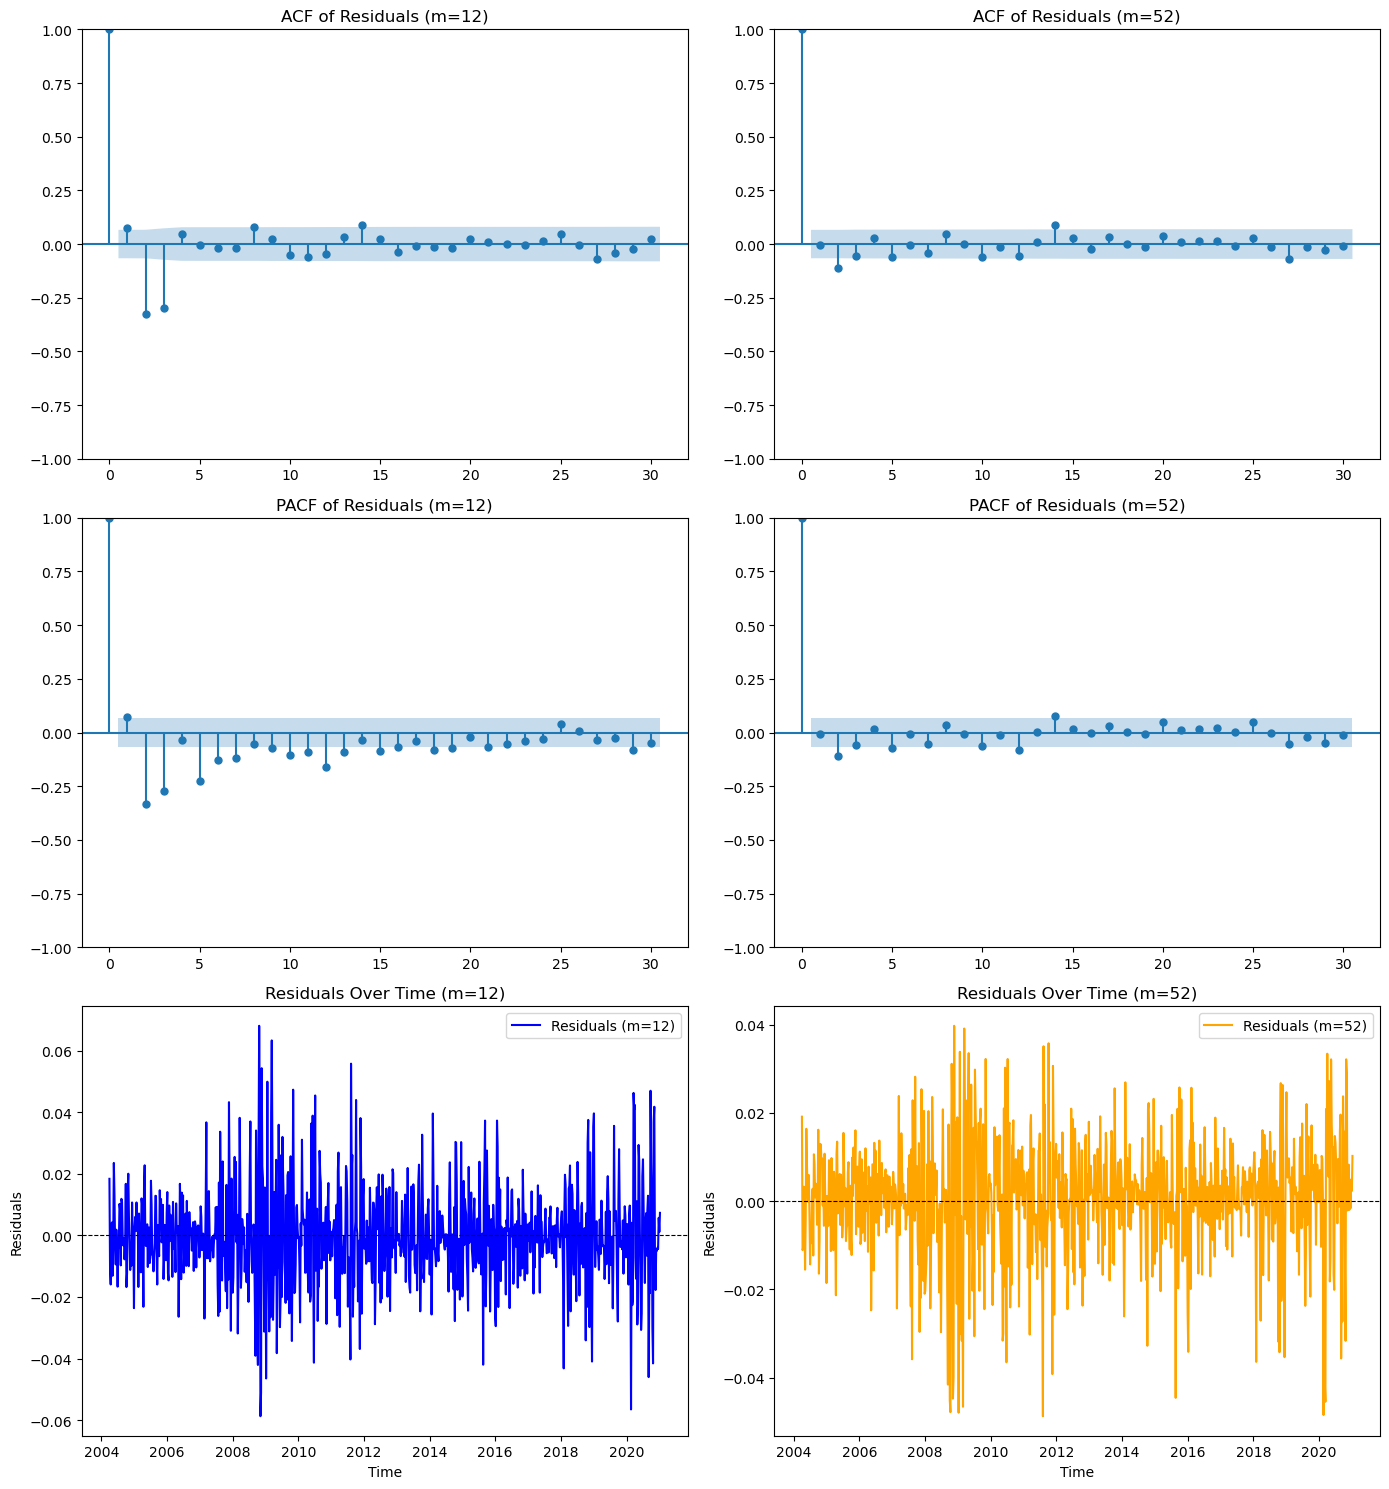

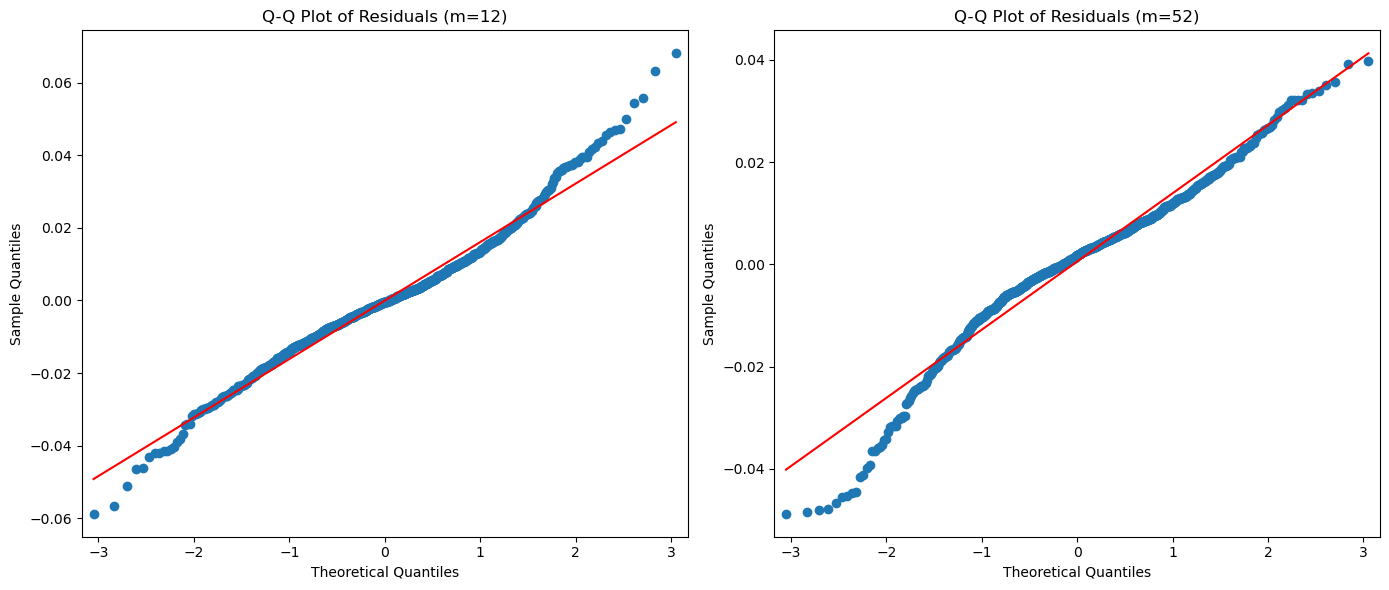

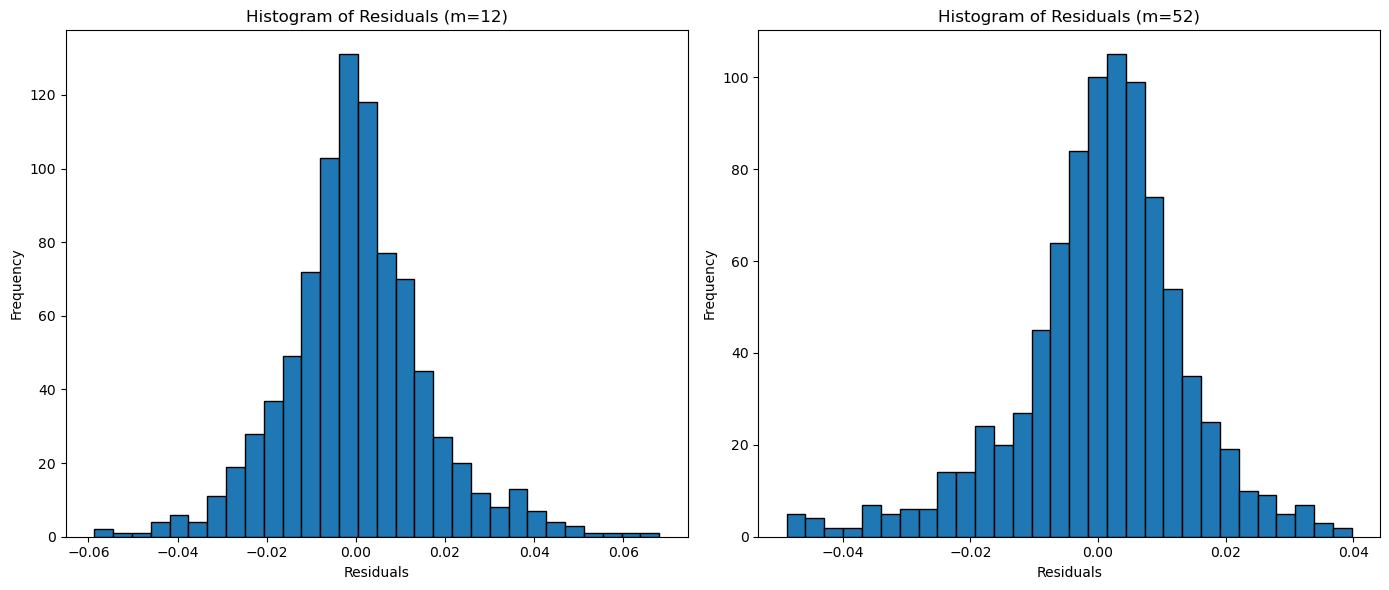

In [60]:
# Side-by-side comparison for ACF and PACF
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # Layout for 3 rows: ACF, PACF, Residual Variance

# ACF for m=12
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0, 0])
ax[0, 0].set_title('ACF of Residuals (m=12)')

# ACF for m=52
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0, 1])
ax[0, 1].set_title('ACF of Residuals (m=52)')

# PACF for m=12
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1, 0])
ax[1, 0].set_title('PACF of Residuals (m=12)')

# PACF for m=52
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1, 1])
ax[1, 1].set_title('PACF of Residuals (m=52)')

# Residual Variance Over Time for m=12
ax[2, 0].plot(residuals, label='Residuals (m=12)', color='blue')
ax[2, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax[2, 0].set_title('Residuals Over Time (m=12)')
ax[2, 0].set_xlabel('Time')
ax[2, 0].set_ylabel('Residuals')
ax[2, 0].legend()

# Residual Variance Over Time for m=52
ax[2, 1].plot(residuals_52, label='Residuals (m=52)', color='orange')
ax[2, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax[2, 1].set_title('Residuals Over Time (m=52)')
ax[2, 1].set_xlabel('Time')
ax[2, 1].set_ylabel('Residuals')
ax[2, 1].legend()

plt.tight_layout()
plt.show()

# Side-by-side comparison for Q-Q plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Q-Q plot for m=12
sm.qqplot(residuals, line='s', ax=ax[0])
ax[0].set_title('Q-Q Plot of Residuals (m=12)')

# Q-Q plot for m=52
sm.qqplot(residuals_52, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot of Residuals (m=52)')

plt.tight_layout()
plt.show()

# Side-by-side comparison for Histogram
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for m=12
ax[0].hist(residuals, bins=30, edgecolor='k')
ax[0].set_title('Histogram of Residuals (m=12)')
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')

# Histogram for m=52
ax[1].hist(residuals_52, bins=30, edgecolor='k')
ax[1].set_title('Histogram of Residuals (m=52)')
ax[1].set_xlabel('Residuals')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**ACF/PACF plots**: Looking at the figures, it shows that the residuals for quaterly frequency (m=12) has significant spikes ACF (lag 2 adn 3) and PACF (numerous lags). Meanwhile, the annual frequency (m=52) shows that the residuals are mostly located in the confidence of interval. The images suggest that m=52 was better able to capture auto-correlation and dependecies compared to the m=12. 

**Residuals Over Time**: By observing the plots the model using quaterly frequency presented a figure with less residual variance. Although, both presents clustered volatility (biggest one is in 2009). The plots might indicate that the variance is slighty more stable in the m=12.

**Q-Q Plots**: The m=12 shows that most of values are following normal distribution, but it deviates when looked at the tails, which is also observable in the skewness of the histogram. On the other hand, the m=52 also shows that the line follows the red diagonal, but the longer frequency has cleary deviations on one side of the tail. The Q-Q plots suggests that the r esiduals of m=52 might be closer to normality than m=12.  

**Arch and Ljung-BoxTest**: Both frequencies presented p-value lower than 0.05 for the Arch test, however the m=52 presented higher value (Quaterly - 4.54e-34 / Annual = 7.97e-24), less heteroscedasticity. The auto-correlation test also indicates that both M's still presents signs of it and despite being below 0.05 the p-value for m=52 is way above m=12.  

## Model Selection

The frequency selected for the baseline model is the annual frequency with the following parameters. **(1,0,3) (1,0,2, 52)**. 
The selection of the model is based one the balance between accuracy performance and residual analysis:
- The m=12 has a slighest better performance when compare to the m=52, but both presents RMSE that are lower than the standard deviation, so as the values for its train and test not being far from each other.
- The m=52 outperformed the m=12, by capturing the autocorrelation and dependencies in the data.
- The annual frequency had their residuals better normal distributed.   